# Pulling meteorological data
This notebook walks through using the SC ACIS API so we can pull weather station data from around North Carolina.

All information on the API can be found here (https://www.rcc-acis.org/docs_webservices.html).

## Step 1 - Pull the stations
First, we would like to get a list of all of the stations that exist in North Carolina. We can do this by using the StnMeta API. We would like to:
1. Get the list of stations.
2. Clean the output so we can save as a dataframe for future reference.
3. Visualize the stations throughout the state.

In [42]:
"""
In this cell, we pull the list of stations that report daily maximum temperature.
"""

import requests, json, pandas as pd

URL = "https://data.rcc-acis.org/StnMeta"

params = {
    "state": "NC",
    "elems": "maxt",                      # required so ACIS lists stations
    "meta": "uid,name,state,sids,ll,elev,valid_daterange"
}

resp = requests.post(URL, json={"params": params}, timeout=30)
resp.raise_for_status()

In [43]:
# Now, we have to parse the json to create a dataframe of stations
stations = resp.json()['meta']
print(stations[0].keys())

dict_keys(['name', 'll', 'sids', 'state', 'elev', 'valid_daterange', 'uid'])


When you print out the keys, you see that we have:
* Name - the station name
* ll - the lat and lon
* sids - a list of identifiers for the station (we can just save the first identifier)
* elev - the elevation of the station
* valid_daterange - start and end date
* uid - unified acis id

In [ ]:
items = []
for s in stations:
    if 'll' in s.keys():
        lon, lat = s['ll']
    else:
        lon, lat = None, None
    sid = s['sids'][0]
    start_date, end_date = s['valid_daterange'][0]
    if 'elev' in s.keys(): 
        elev = s['elev']
    else:
        elev = None
    items.append({
        "name": s['name'],
        "sid": sid,
        "lat": lat,
        "lon": lon,
        "elev": elev,
        "start_date": start_date,
        "end_date": end_date,
        "uid": s['uid']
    })

df = pd.DataFrame(items)
df.to_csv("../data/acis_stations.csv", index=False)

Text(0.5, 1.0, 'Stations in North Carolina Reporting Daily Maximum Temperature')

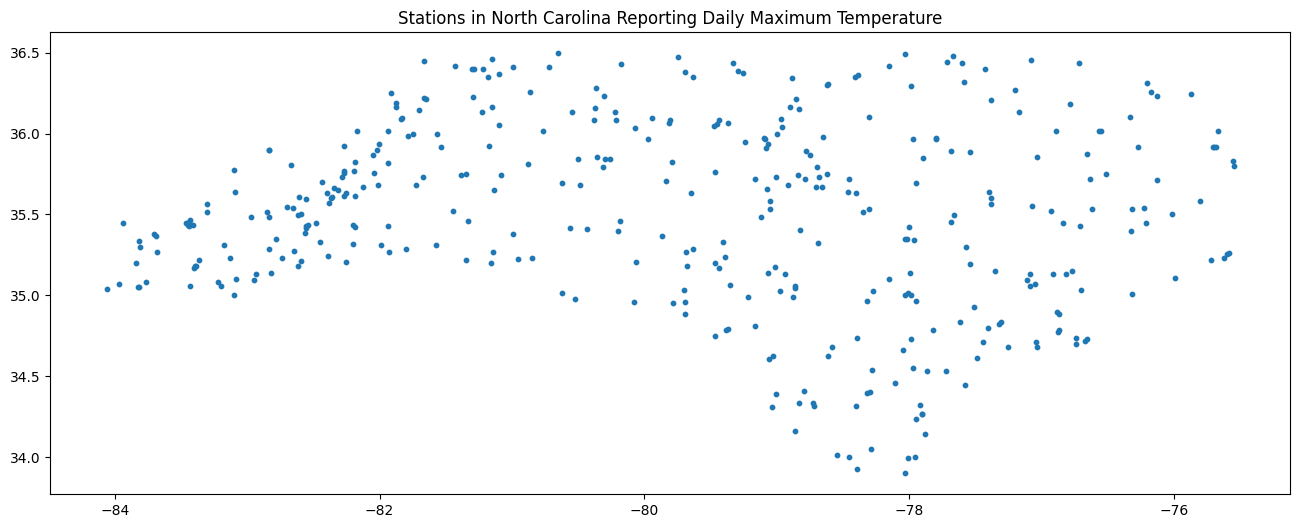

In [66]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
plt.scatter(df['lon'], df['lat'], s=10)
plt.title("Stations in North Carolina Reporting Daily Maximum Temperature")

# Step 2 - Pull the meteorological data
Now, we would like to iterate through the list of the stations, and pull all the data. For each station, we would like to:
1. Pull the data going back as far back as its start date.
2. Organize the data into a CSV format, and save (1 file per station).

Before pulling the data, let's first review the stations and only pull data for stations that have a start date before 1985 and an end date after 2020. This will make sure that we are only getting long-term records for each station.

In [67]:
df = pd.read_csv('../data/acis_stations.csv')
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

print(f"Starting number of stations: {len(df)}")
df = df[(df['start_date'] < '1985-01-01') & (df['end_date'] > '2020-01-01')]
df = df.reset_index(drop=True)
print(f"Number of stations to pull: {len(df)}")

Starting number of stations: 400
Number of stations to pull: 118


Text(0.5, 1.0, 'Stations in North Carolina Reporting Daily Maximum Temperature')

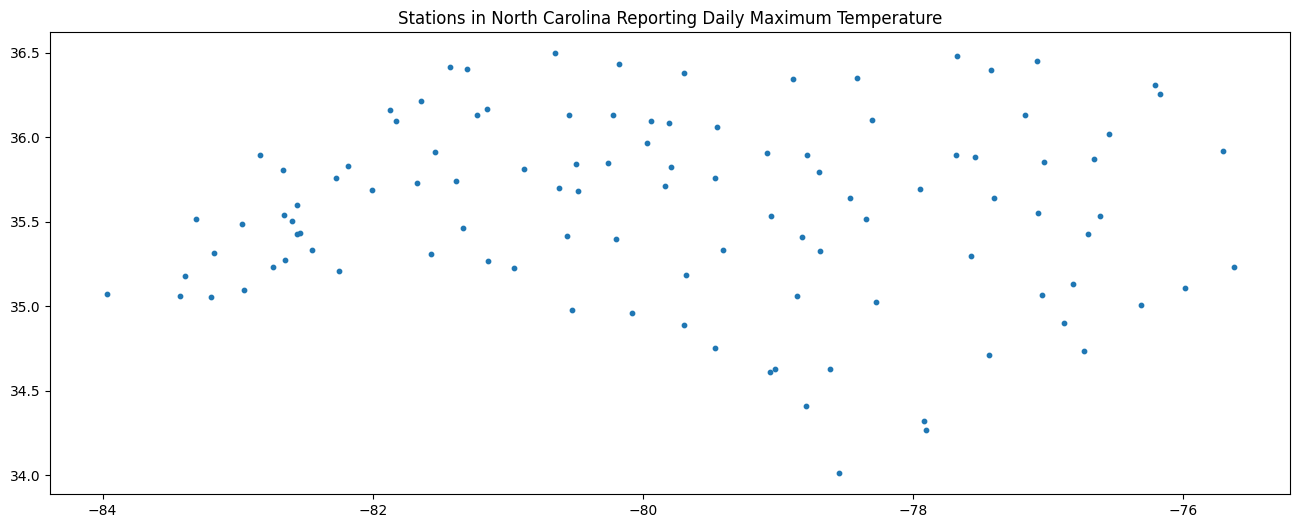

In [68]:
plt.figure(figsize=(16,6))
plt.scatter(df['lon'], df['lat'], s=10)
plt.title("Stations in North Carolina Reporting Daily Maximum Temperature")

That was potentially a wise move...as we have restricted the stations significantly. It may be that we want to go back and get that data in the future, but for now, this is a good start.

### Let's pull the data now.

In [87]:
import os
for idx, row in df.iterrows():

    if os.path.exists(f"../data/station_data/{row['uid']}.csv"):
        continue
    print(f"Pulling data for station {row['sid']} ({idx+1} of {len(df)})")
    URL = "https://data.rcc-acis.org/StnData"
    params = {
        "sid": row['sid'],
        "sdate": row['start_date'].strftime('%Y-%m-%d'),
        "edate": row['end_date'].strftime('%Y-%m-%d'),
        "elems": ["maxt", "mint", 'avgt', 'obst', 'pcpn']
        # "output": "csv"
    }

    resp = requests.post(URL, json={"params": params}, timeout=30)
    resp.raise_for_status()

    res = pd.DataFrame(resp.json()['data'], columns=['date', 'maxt', 'mint', 'avgt', 'obst', 'pcpn'])

    for col in ['maxt', 'mint', 'avgt', 'obst', 'pcpn']:
        res[col] = pd.to_numeric(res[col], errors='coerce')

    res['date'] = pd.to_datetime(res['date'])
    res = res.set_index('date').sort_index()
    
    res.to_csv(f"../data/station_data/{row['uid']}.csv")

Pulling data for station 319100 2 (1 of 118)
Pulling data for station 317994 2 (2 of 118)
Pulling data for station 317656 2 (3 of 118)
Pulling data for station 310724 2 (4 of 118)
Pulling data for station 316341 2 (5 of 118)
Pulling data for station 310674 2 (6 of 118)
Pulling data for station 312837 2 (7 of 118)
Pulling data for station 313638 2 (8 of 118)
Pulling data for station 13872 1 (9 of 118)
Pulling data for station 311820 2 (10 of 118)
Pulling data for station 317615 2 (11 of 118)
Pulling data for station 315340 2 (12 of 118)
Pulling data for station 319476 2 (13 of 118)
Pulling data for station 317924 2 (14 of 118)
Pulling data for station 310286 2 (15 of 118)
Pulling data for station 13784 1 (16 of 118)
Pulling data for station 318292 2 (17 of 118)
Pulling data for station 315838 2 (18 of 118)
Pulling data for station 317097 2 (19 of 118)
Pulling data for station 314970 2 (20 of 118)
Pulling data for station 311624 2 (21 of 118)
Pulling data for station 312719 2 (22 of 118)

## A simple analysis of trends
To visualize the data, I'm going to perform a very simple analysis. I'm just going to iterate through the list of stations, and:
1. Filter out stations which have a large number of missing data.
2. Fit a slope on maxT and minT
3. Create a plot of temperature increases over North Carolina.

In [112]:
results = []

uids = df['uid']

for i, uid in enumerate(uids):
    if i % 10 == 0:
        print(f"Processing station {i+1} of {len(uids)}")
    station = pd.read_csv(f"../data/station_data/{uid}.csv", parse_dates=['date'])

    # Only look at the time period we care about
    station = station[station['date'] >= '1985-01-01']
    station = station[station['date'] <= '2024-01-01']
    
    # If more than 20% of the data is missing, skip
    if np.isnan(station['maxt']).values.mean() > 0.2:
        continue

    # Remove rows with NaN values
    station = station.dropna(subset=['maxt', 'mint'])
    
    # First convert dates to ordinal
    station['date_ordinal'] = station['date'].apply(lambda x: x.toordinal())
    
    X = station['date_ordinal'].values.reshape(-1, 1)
    # Subtract the ordinal date of 1985-01-01 to improve conditioning
    X = X - pd.Timestamp('1985-01-01').toordinal()

    # Add an intercept
    X = np.hstack([X, np.ones_like(X)])
    y_max = station['maxt'].values
    y_min = station['mint'].values

    beta = np.linalg.lstsq(X, y_max, rcond=None)[0]

    slope_max = beta[0] * 365.25  # Convert to per year
    slope_min = np.linalg.lstsq(X, y_min, rcond=None)[0][0] * 365.25
    results.append({
        "uid": uid,
        "lat": df[df['uid'] == uid]['lat'].values[0],
        "lon": df[df['uid'] == uid]['lon'].values[0],
        "slope_max": slope_max,
        "slope_min": slope_min
    })
    # break


Processing station 1 of 118
Processing station 11 of 118
Processing station 21 of 118
Processing station 31 of 118
Processing station 41 of 118
Processing station 51 of 118
Processing station 61 of 118
Processing station 71 of 118
Processing station 81 of 118
Processing station 91 of 118
Processing station 101 of 118
Processing station 111 of 118


In [119]:
pd.DataFrame(results).to_csv("../data/station_trends.csv", index=False)

In [ ]:
results = pd.DataFrame(results)
results.to_csv("../data/station_trends.csv", index=False)

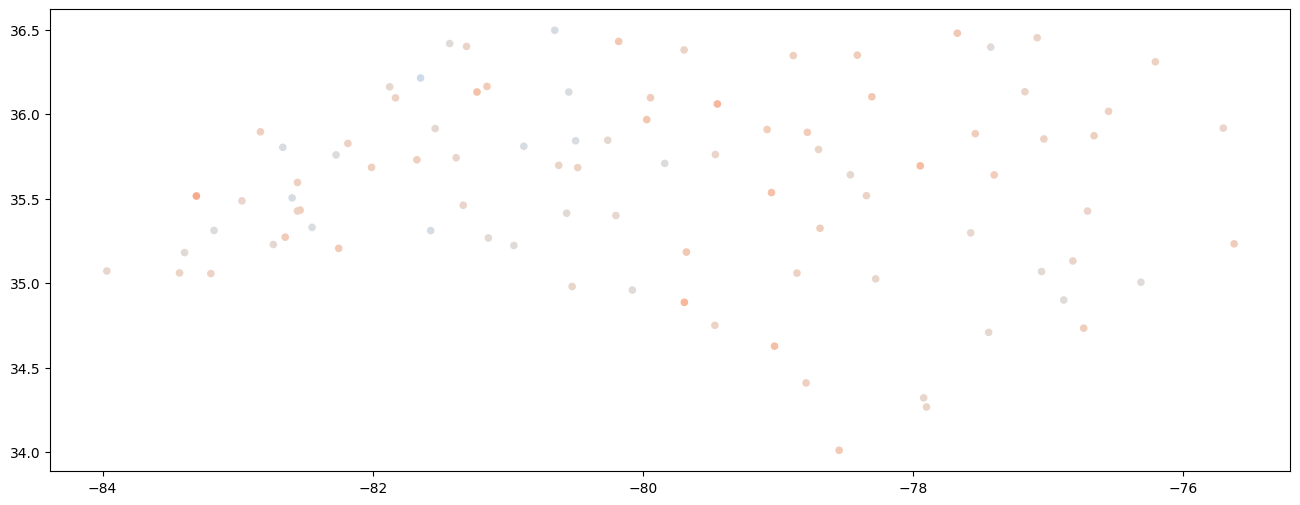

In [125]:
plt.figure(figsize=(16,6))
plt.scatter(results['lon'], results['lat'], c=results['slope_min'], s=20, cmap='coolwarm', vmin=-0.5, vmax=0.5)
plt.show()

## Potential next steps
This map shows that there is a weak trend on average temperatures. We will want to review this trend, and potentially dig into monthly averages.

To do this correctly, we should consider:
1. Imputation strategies -- how should we fill in missing values?
2. Interpolation strategies -- how can we fill in the gaps to get a spatially complete map of temperature trends in the State?
3. Alternative metrics of interest. For example, how has the number of days with max temp > 95°F changed over time?